# here's a libc

**Shall we begin**

### step 1 - put it in ghidra

done, and heres our main function

```C
void main(undefined4 param_1,undefined8 param_2)

{
  uint uVar1;
  char acStack168 [24];
  undefined8 uStack144;
  undefined8 local_88;
  undefined4 local_7c;
  undefined8 local_78;
  undefined8 local_70;
  undefined8 local_68;
  undefined2 local_60;
  undefined local_5e;
  char *local_50;
  undefined8 local_48;
  ulong local_40;
  __gid_t local_34;
  ulong local_30;
  
  uStack144 = 0x40079c;
  local_88 = param_2;
  local_7c = param_1;
  setbuf(stdout,(char *)0x0);
  uStack144 = 0x4007a1;
  local_34 = getegid();
  uStack144 = 0x4007bb;
  setresgid(local_34,local_34,local_34);
  local_40 = 0x1b;
  local_78 = 0x20656d6f636c6557;
  local_70 = 0x636520796d206f74;
  local_68 = 0x6576726573206f68;
  local_60 = 0x2172;
  local_5e = 0;
  local_48 = 0x1a;
  local_50 = acStack168;
  local_30 = 0;
  while (local_30 < local_40) {
    uVar1 = convert_case(*(byte *)((long)&local_78 + local_30),local_30);
    local_50[local_30] = (char)uVar1;
    local_30 = local_30 + 1;
  }
  puts(local_50);
  do {
    do_stuff();
  } while( true );
}
```

### step 2 - find flag

what are we here for? to find the flag obvi. unlike some of the other challenges, its not just being loaded in the main function, so we have to find places where the flag might be. searching in both the `vuln` and `libc.so.6` files, we dont see any `open` function calls on any files that look like they would contain the flag. 

however, 

```C
local_34 = getegid();
uStack144 = 0x4007bb;
setresgid(local_34,local_34,local_34);
```

these lines look somewhat suspicious, which might mean that the flag is actually the group name or something - however, `getegid` returns a `gid_t`, which is an [integer data type](https://www.gnu.org/software/libc/manual/html_node/Reading-Persona.html), so we might not be able to use that directly. 

```C
  local_78 = 0x20656d6f636c6557;
  local_70 = 0x636520796d206f74;
  local_68 = 0x6576726573206f68;
  local_60 = 0x2172;
``` 

these lines also look suspiciously like ASCII. putting it into cyber chef and swapping the endianness, we get 

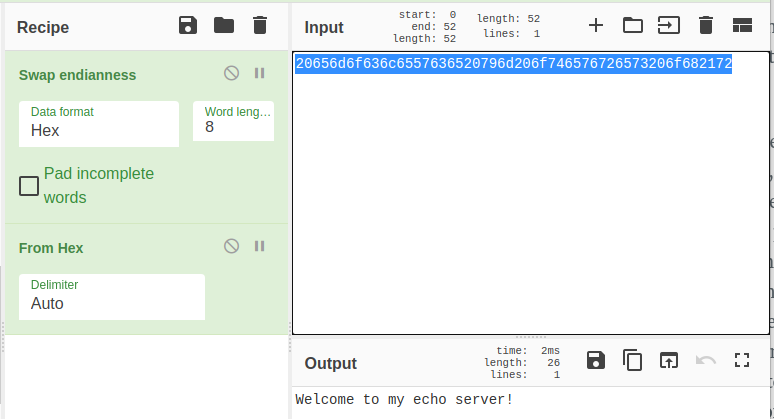

which is good, but its still not the flag. 

digging around in the `libc.so.6`, we also dont really see anything interesting... which probably means that the flag is not in the binary, and instead we have to get access to the flag somewhere outside of the binary's memory space (aka **its probably in a flat file on the host OS**).


### step 3 - find a bug that gives us a shell or something

at this point, we know that the program is vulnerable to SOMETHING. but we dont know what it is vulnerable to. I've decided to give angr a shot, even tho i dont think I like sat solvers fundamentally. but first we probably want to get the program able to run locally, because as it is things dont work

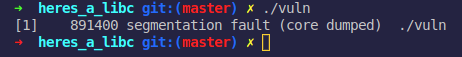


#### 3.1 - make vuln run again

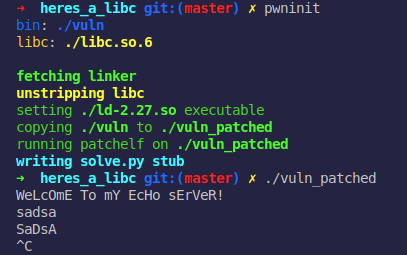


#### 3.2 - inital steps in angr




In [1]:
import angr, monkeyhex
proj = angr.Project('vuln_patched')

In [4]:
def check_mem_corruption(simgr):
    if len(simgr.unconstrained):
        for path in simgr.unconstrained:
            if path.satisfiable(extra_constraints=[path.regs.pc == b"CCCC"]):
                path.add_constraints(path.regs.pc == b"CCCC")
                if path.satisfiable():
                    simgr.stashes['mem_corrupt'].append(path)
                simgr.stashes['unconstrained'].remove(path)
                simgr.drop(stash='active')
    return simgr

In [ ]:
state = proj.factory.entry_state()

simgr = proj.factory.simgr(state, save_unconstrained=True)
simgr.stashes['mem_corrupt']  = []

simgr.explore(step_func=check_mem_corruption)

WARNING | 2021-11-03 16:04:02,139 | angr.storage.memory_mixins.default_filler_mixin | The program is accessing memory or registers with an unspecified value. This could indicate unwanted behavior.
WARNING | 2021-11-03 16:04:02,140 | angr.storage.memory_mixins.default_filler_mixin | angr will cope with this by generating an unconstrained symbolic variable and continuing. You can resolve this by:
WARNING | 2021-11-03 16:04:02,140 | angr.storage.memory_mixins.default_filler_mixin | 1) setting a value to the initial state
WARNING | 2021-11-03 16:04:02,141 | angr.storage.memory_mixins.default_filler_mixin | 2) adding the state option ZERO_FILL_UNCONSTRAINED_{MEMORY,REGISTERS}, to make unknown regions hold null
WARNING | 2021-11-03 16:04:02,141 | angr.storage.memory_mixins.default_filler_mixin | 3) adding the state option SYMBOL_FILL_UNCONSTRAINED_{MEMORY,REGISTERS}, to suppress these messages.
WARNING | 2021-11-03 16:04:02,141 | angr.storage.memory_mixins.default_filler_mixin | Filling memo